In [1]:
import numpy as np
import forward.common as common
import forward.homogeneous_semi_inf as semi_inf
import forward.homogeneous_inf_slab as slab
import inverse.fit_homogeneous as fit_hom
import utils.noise as noise
import matplotlib.pyplot as plt

# Generate some curves

In [2]:
tau = np.load("data/tau.npz")["tau_hardware"]
lambda0 = 785
mua = 0.01
musp = 10
rho = 2
d = rho
n = 1.4
db = [1e-9, 2e-9, 5e-9, 1e-8, 2e-8, 5e-8]
beta = 0.5

Let's see how many terms are needed for the summation in the g1_transmittance function to converge.

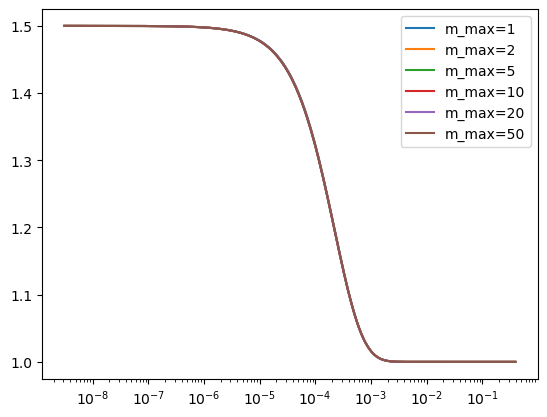

In [25]:
m_max = [1, 2, 5, 10, 20, 50]
msd = common.msd_brownian(tau, db[0])
plt.figure()
for m_max_ in m_max:
    g1_norm_semi_inf = slab.g1_transmittance_norm(msd, mua, musp, 0, n, lambda0, d, m_max=m_max_)
    g2_norm_semi_inf = 1 + beta * g1_norm_semi_inf ** 2
    plt.semilogx(tau, g2_norm_semi_inf, label=f"m_max={m_max_}")

plt.legend()
plt.show()

Let's compare the g2 curves for the semi-infinite and slab geometries.

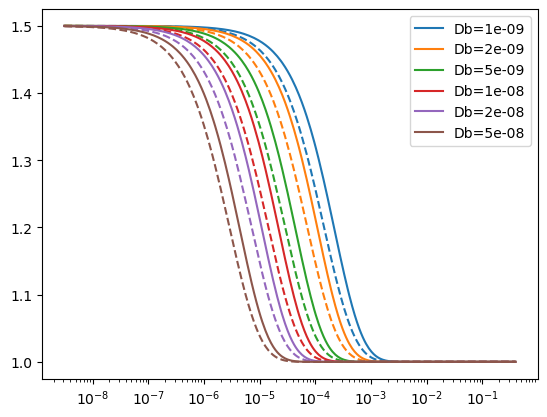

In [4]:
g1_norm_semi_inf = np.zeros((len(tau), len(db)))
g1_norm_slab = np.zeros((len(tau), len(db)))

for i in range(len(db)):
    msd = common.msd_brownian(tau, db[i])
    g1_norm_semi_inf[:, i] = slab.g1_transmittance_norm(msd, mua, musp, 0, n, lambda0, d, m_max=10)
    g1_norm_slab[:, i] = semi_inf.g1_norm(msd, mua, musp, rho, n, lambda0)

g2_norm_semi_inf = 1 + beta * g1_norm_semi_inf ** 2
g2_norm_slab = 1 + beta * g1_norm_slab ** 2
# Use the same color for the same db value
plt.figure()
for i in range(len(db)):
    plt.semilogx(tau, g2_norm_semi_inf[:, i], label=f"Db={db[i]}", color=f"C{i}")
    plt.semilogx(tau, g2_norm_slab[:, i], linestyle='--', color=f"C{i}")
plt.legend()
plt.show()

# Add noise

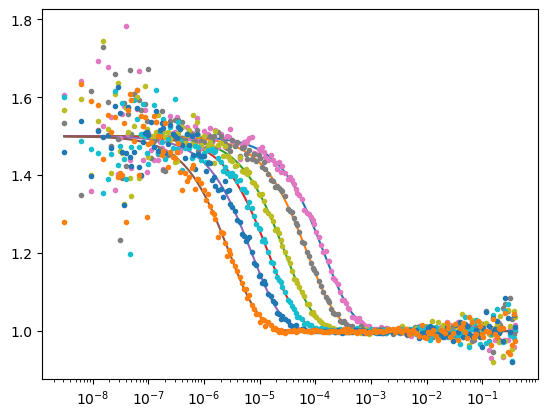

In [5]:
noise_adder = noise.NoiseAdder(
    g2_norm=g2_norm_slab,
    tau=tau,
    t_integration=1,
    countrate=100e3,
    beta=0.5,
    n_speckle=4,
    mua=mua,
    musp=musp,
    db=np.array(db),
    lambda0=lambda0
)

g2_norm_noisy = noise_adder.add_noise()
plt.semilogx(tau, g2_norm_slab)
plt.semilogx(tau, g2_norm_noisy, linestyle='none', marker='.')
plt.show()

In [25]:
beta_calculator =  fit_hom.BetaCalculator(mode="fixed", beta_fixed=0.50)
#beta_calculator = fit_hom.BetaCalculator(mode="raw", tau_lims=(1e-7, 2e-7))
#beta_calculator = fit_hom.BetaCalculator(mode="raw_weighted", tau_lims=(1e-7, 2e-7), beta0=0.50)
#beta_calculator = fit_hom.BetaCalculator(mode="fit", beta_init=0.48, beta_bounds=(0.47, 0.51))
msd_model = fit_hom.MSDModelFit(model_name="brownian", param_init={"db": 1e-8}, param_bounds={"db": (0, None)})
#msd_model = fit_hom.MSDModel(model_name="ballistic", param_init={"v_ms": 2e-4}, param_bounds={"v_ms": (0, None)})
#msd_model = fit_hom.MSDModel(model_name="hybrid", param_init={"db": 2e-8, "v_ms": 1e-4}, param_bounds={"db": (0, None), "v_ms": (0, None)})
fitter = fit_hom.FitHomogeneous(
    tau,
    g2_norm_noisy,
    slab.g1_transmittance_norm,
    msd_model,
    beta_calculator,
    tau_lims_fit=(1e-7, 1e-3),
    g2_lim_fit=1.13,
    plot_interval=0,
    mua=mua,
    musp=musp,
    rho=0,
    n=n,
    lambda0=lambda0,
    d=d,
    m_max=2
)

fitted_data = fitter.fit()
fitted_data

,db,beta
0,1.516718e-09,0.5
1,3.065363e-09,0.5
2,7.595677e-09,0.5
3,1.505925e-08,0.5
4,3.054315e-08,0.5
5,7.764806e-08,0.5
